In [2]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
from scipy.optimize import minimize 

plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision = 5, suppress = True, formatter={'float':lambda x: f'{x:6.3f}'})
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
raw = pd.read_csv(url, index_col = 0, parse_dates=True).dropna()
#recuperiamo di dati storoci di EOD, da una postazione remota
raw.info()

<ipython-input-2-c48a0a17e6ca>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


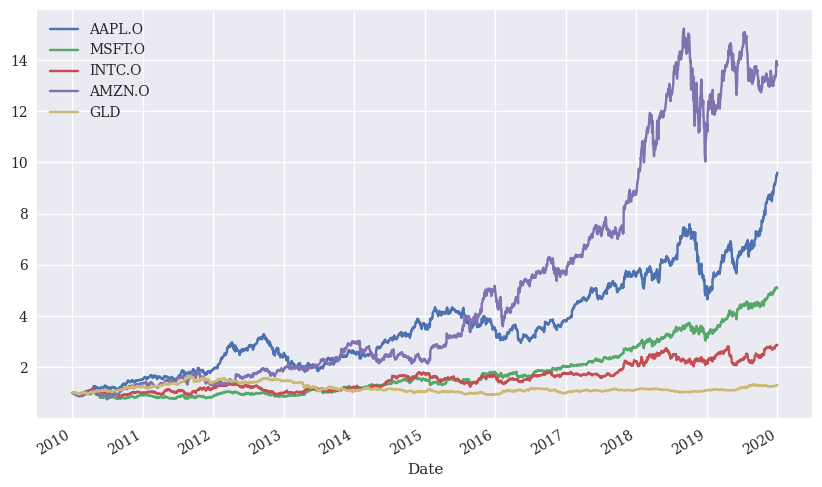

In [3]:
#specifichiamo i simboli (RIC) in cui investire
symbols = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GLD']

#calcolaliamo i rendimenti logaritmici per tutte le serie temporali
rets = np.log(raw[symbols] / raw[symbols].shift(1)).dropna()

#tracciamo il grafico delle serie temporali finanziarie normalizzate per 
#i simboli selezionati
(raw[symbols] / raw[symbols].iloc[0]).plot(figsize=(10, 6));

In [4]:
#portafoglio equamente ponderato
weights = len(rets.columns) * [1 / len(rets.columns)]

#rendimento del portafoglio
def port_return(rets, weights):
    return np.dot(rets.mean(), weights) * 252

port_return(rets, weights)

0.156947646530181

In [5]:
#volatilità del portafoglio
def port_volatility(rets, weights):
    return np.dot(weights, np.dot(rets.cov() * 252 , weights)) ** 0.5

port_volatility(rets, weights)

0.16106507848480675

In [6]:
#Sharpe ratio del portafoglio (con tasso a breve pari a zero)
def port_sharpe(rets, weights):
    return port_return(rets, weights) / port_volatility(rets, weights) 

port_sharpe(rets, weights)

0.9744362217225496

In [7]:
#pesi del portafoglio simulati pari a 100%
w = np.random.random((1000, len(symbols)))
w = (w.T / w.sum(axis=1)).T
w[:5]

array([[ 0.216,  0.121,  0.256,  0.255,  0.153],
       [ 0.125,  0.369,  0.153,  0.031,  0.322],
       [ 0.227,  0.005,  0.221,  0.288,  0.260],
       [ 0.297,  0.267,  0.275,  0.055,  0.106],
       [ 0.418,  0.020,  0.413,  0.012,  0.136]])

In [8]:
#deriva i risultati dei rendimenti e volatilità del portafoglio
pvr = [(port_volatility(rets[symbols], weights),
        port_return(rets[symbols], weights))
        for weights in w] 
pvr = np.array(pvr)

#calcola lo sharpe ratio risulatante
psr = pvr[:, 1] / pvr[:, 0]

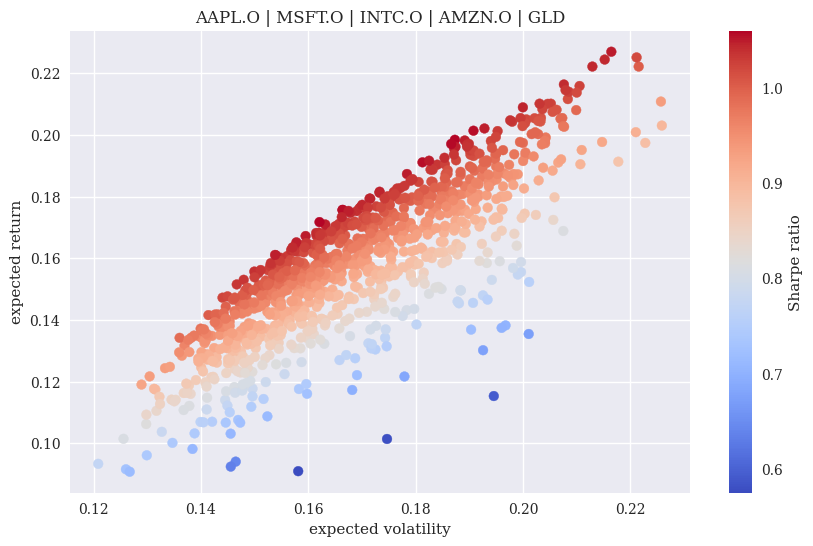

In [9]:
plt.figure(figsize=(10, 6))
fig = plt.scatter(pvr[:, 0], pvr[:, 1],c=psr, cmap='coolwarm')
cb = plt.colorbar(fig)
cb.set_label('Sharpe ratio')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.title(' | '.join(symbols));

In [10]:
#specifica i limiti per i pesi dei singoli assets
bnds = len(symbols) * [(0, 1),]
bnds

[(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

In [13]:
#specifica che tutti i pesi devono sommarsi fino al 100%
cons = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

In [14]:
opt_weights = {}
for year in range(2010, 2019):
    rets_ = rets[symbols].loc[f'{year}-01-01':f'{year}-12-31'] #seleziona l'insieme di dati pertinente per l'anno specificato
    ow = minimize(lambda weights: -port_sharpe(rets_, weights),
                  len(symbols) * [1 / len(symbols)],
                  bounds=bnds,
                  constraints=cons)['x'] #deriva i pesi del portafoglio che massimizzano lo Sharpe ratio
    opt_weights[year] = ow #memorizza tali pesi in un oggetto dict
opt_weights            

{2010: array([ 0.366,  0.000,  0.000,  0.056,  0.578]),
 2011: array([ 0.543,  0.000,  0.077,  0.000,  0.380]),
 2012: array([ 0.324,  0.000,  0.000,  0.471,  0.205]),
 2013: array([ 0.012,  0.305,  0.219,  0.464,  0.000]),
 2014: array([ 0.452,  0.115,  0.419,  0.000,  0.015]),
 2015: array([ 0.000,  0.000,  0.000,  1.000,  0.000]),
 2016: array([ 0.150,  0.260,  0.000,  0.058,  0.533]),
 2017: array([ 0.231,  0.203,  0.031,  0.109,  0.426]),
 2018: array([ 0.000,  0.295,  0.000,  0.705,  0.000])}

In [15]:
res = pd.DataFrame()
for year in range(2010, 2019):
    rets_ = rets[symbols].loc[f'{year}-01-01':f'{year}-12-31']
    #statistiche di portafoglio attese
    epv = port_volatility(rets_, opt_weights[year]) 
    epr = port_return(rets_, opt_weights[year])
    esr = epr / epv 
    rets_ = rets[symbols].loc[f'{year + 1}-01-01':f'{year + 1}-12-31']
    #statistiche di portafoglio realizzate
    rpv = port_volatility(rets_, opt_weights[year])
    rpr = port_return(rets_, opt_weights[year]) 
    rsr = rpr / rpv
    res = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,
                                    'rpv': rpv, 'rpr': rpr, 'rsr': rsr},
                                    index=[year + 1]))
res

<ipython-input-15-b1f981b0181b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,
<ipython-input-15-b1f981b0181b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,
<ipython-input-15-b1f981b0181b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,
<ipython-input-15-b1f981b0181b>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(pd.DataFrame({'epv': epv, 'epr': epr, 'esr': esr,
<ipython-input-15-b1f981b0181b>:13: FutureWarnin

,epv,epr,esr,rpv,rpr,rsr
2011,0.157440,0.303003,1.924564,0.160622,0.133836,0.833235
2012,0.173279,0.169321,0.977156,0.182292,0.161375,0.885256
2013,0.202460,0.278459,1.375378,0.168714,0.166897,0.989228
2014,0.181544,0.368961,2.032353,0.197798,0.026830,0.135645
2015,0.160340,0.309486,1.930190,0.211368,-0.024560,-0.116194
2016,0.326730,0.778330,2.382179,0.296565,0.103870,0.350242
2017,0.106148,0.090933,0.856663,0.079521,0.230630,2.900235
2018,0.086548,0.260702,3.012226,0.157337,0.038234,0.243004
2019,0.323796,0.228008,0.704174,0.207672,0.275819,1.328147


In [16]:
res.mean()

epv    0.190920
epr    0.309689
esr    1.688320
rpv    0.184654
rpr    0.123659
rsr    0.838755
dtype: float64

In [17]:
res[['epv', 'rpv']].corr()

,epv,rpv
epv,1.000000,0.765733
rpv,0.765733,1.000000


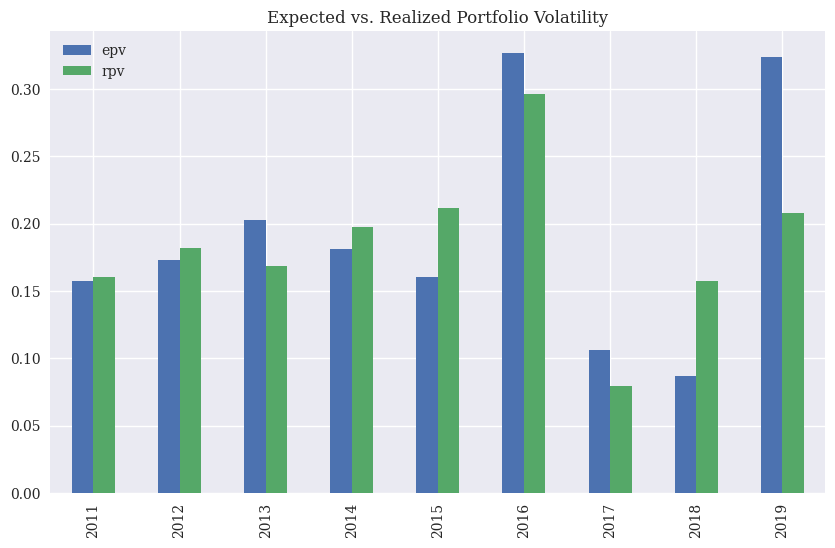

In [19]:
res[['epv', 'rpv']].plot(kind='bar', figsize=(10, 6),
    title='Expected vs. Realized Portfolio Volatility');

In [20]:
res[['epr', 'rpr']].corr()

,epr,rpr
epr,1.000000,-0.350437
rpr,-0.350437,1.000000


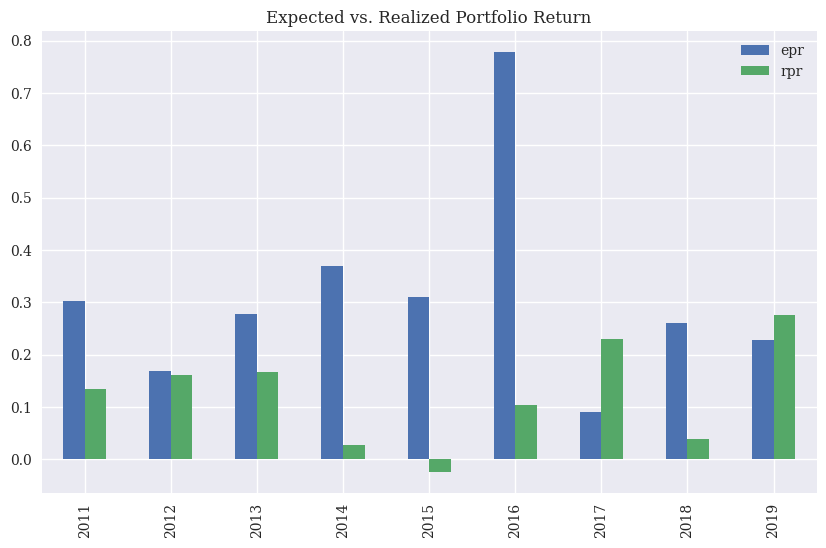

In [21]:
res[['epr', 'rpr']].plot(kind='bar', figsize=(10, 6),
        title='Expected vs. Realized Portfolio Return');

In [22]:
res[['esr', 'rsr']].corr()

,esr,rsr
esr,1.000000,-0.698607
rsr,-0.698607,1.000000


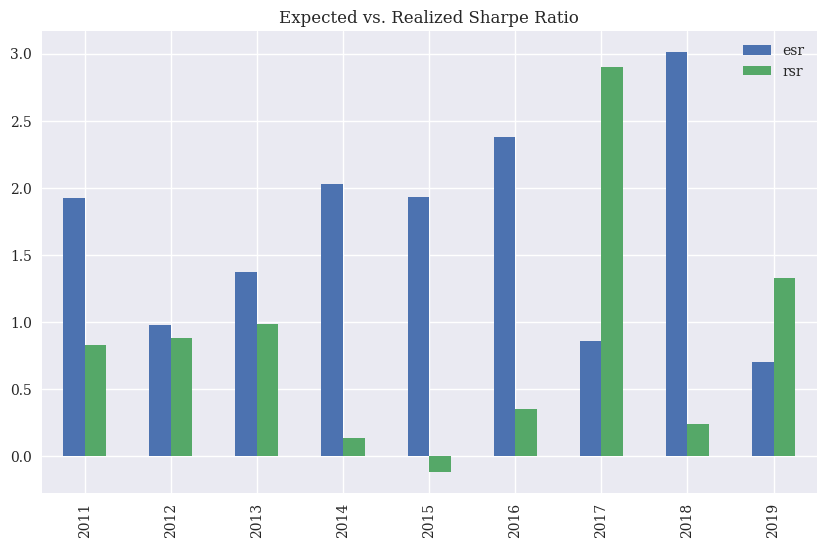

In [23]:
res[['esr', 'rsr']].plot(kind='bar', figsize=(10, 6),
      title='Expected vs. Realized Sharpe Ratio');